## Step 1 — Setup and load processed HO datasets
Set the processed-data path and load three inputs for *Halophila ovalis*:  
- `Ho_monthly_occupancy_2010_2018.csv` (site×month HO occupancy with CIs)  
- `env_drivers_pivot_2010_2018.csv` (monthly eReefs drivers, wide)  
- `Ho_occ_with_env_2010_2018.csv` (merged HO + drivers + lags).  
Parse dates, verify shapes, and extract the site list for plotting and analysis.


In [1]:
# Cell 1 — Setup & load processed data (HO)
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# CHANGE if your path differs
DATA = Path(r"C:\Users\F\Desktop\ENVI5809\data for analysis\processed")
assert DATA.exists(), f"Folder not found: {DATA}"

occ    = pd.read_csv(DATA / "Ho_monthly_occupancy_2010_2018.csv", parse_dates=["date"])
envw   = pd.read_csv(DATA / "env_drivers_pivot_2010_2018.csv",   parse_dates=["date"])
merged = pd.read_csv(DATA / "Ho_occ_with_env_2010_2018.csv",     parse_dates=["date"])

sites  = merged["SURVEY_NAM"].unique().tolist()
print("Loaded:", occ.shape, envw.shape, merged.shape, "| Sites:", sites)

Loaded: (112, 8) (800, 11) (112, 34) | Sites: ['Abbot_Point', 'Cairns', 'Clairview', 'Gladstone', 'HayPoint', 'Mourilyan', 'OSRA', 'Townsville']


## Step 2 — Rescue cell: reload HO data safely
Use this fallback if the main path is unavailable or the notebook runs from a new location.  
Defines `DATA`, checks that all three processed files exist, and reloads them with date parsing.  
Ensures `occ`, `envw`, and `merged` are initialized before plotting or analysis.


In [2]:
# Rescue Cell — define DATA and (re)load the processed CSVs for HO
import pandas as pd
from pathlib import Path

# 👉 set your processed folder here
DATA = Path(r"C:\Users\F\Desktop\ENVI5809\data for analysis\processed")

# fallback: try a local "processed" folder next to the notebook
if not DATA.exists():
    DATA = Path.cwd() / "processed"

occ_path    = DATA / "Ho_monthly_occupancy_2010_2018.csv"
envw_path   = DATA / "env_drivers_pivot_2010_2018.csv"
merged_path = DATA / "Ho_occ_with_env_2010_2018.csv"

for p in (occ_path, envw_path, merged_path):
    assert p.exists(), f"Missing file: {p}"

occ    = pd.read_csv(occ_path, parse_dates=["date"])
envw   = pd.read_csv(envw_path, parse_dates=["date"])
merged = pd.read_csv(merged_path, parse_dates=["date"])

print("Loaded → occ:", occ.shape, "| envw:", envw.shape, "| merged:", merged.shape)

Loaded → occ: (112, 8) | envw: (800, 11) | merged: (112, 34)


## Step 3 — Site × month heatmap of Halophila ovalis occupancy  
Pivot the merged HO dataset to build a site (rows) × month (columns) matrix of mean occupancy `p`.  
Visualize the temporal and spatial variation in *Halophila ovalis* presence using a heatmap (0–1 scale).  
Label y-axis with sites, x-axis with yearly ticks, and save the figure as `fig_heatmap_occupancy_HO.png` inside the `figs` folder.


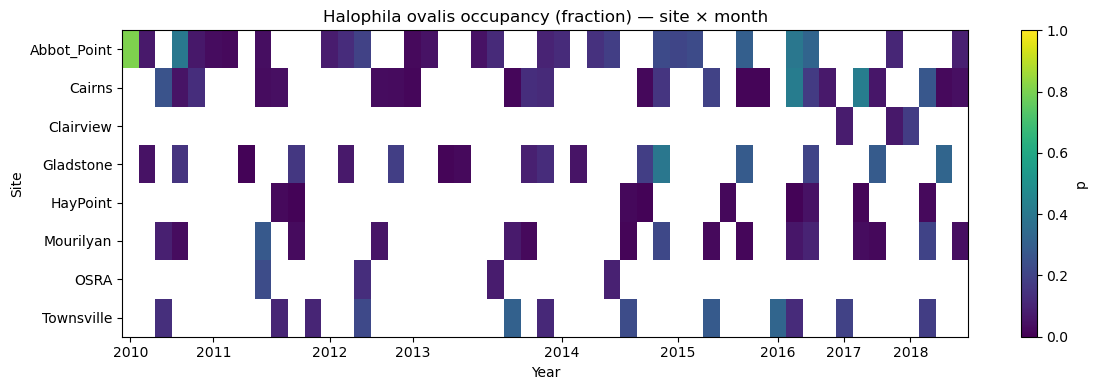

In [3]:
# Heatmap for HO (Halophila ovalis)

# ensure output folder
from pathlib import Path
OUT = (DATA / "figs")
OUT.mkdir(parents=True, exist_ok=True)

heat = merged.pivot_table(index="SURVEY_NAM", columns="date", values="p", aggfunc="mean").sort_index()

plt.figure(figsize=(12,4))
plt.imshow(heat.values, aspect="auto", interpolation="nearest", vmin=0, vmax=1)
plt.yticks(range(len(heat.index)), heat.index)

years = pd.to_datetime(heat.columns).year
xticks = [i for i,y in enumerate(years) if i==0 or years[i-1]!=y]
plt.xticks(xticks, [str(years[i]) for i in xticks])

plt.title("Halophila ovalis occupancy (fraction) — site × month")
plt.xlabel("Year"); plt.ylabel("Site")
plt.colorbar(label="p")
plt.tight_layout()
plt.savefig(OUT / "fig_heatmap_occupancy_HO.png", dpi=300)
plt.show()

## Step 4 — Seasonal cycle of Halophila ovalis occupancy (2010–2018)  
Group monthly occupancy across all years to compute the climatological mean and standard error for each month.  
Plot the mean monthly occupancy pattern with ±SE shading to show seasonal variation in *Halophila ovalis* presence.  
Axis limits are fixed between 0 and 1 for comparability with ZC results.  
The output figure `fig_seasonal_cycle_HO.png` is saved in the `figs` folder.


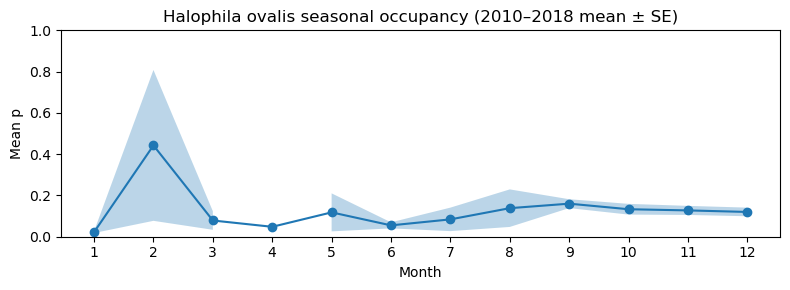

In [4]:
# Seasonal cycle for HO (Halophila ovalis)

occ2 = occ.copy()
occ2["month"] = pd.to_datetime(occ2["date"]).dt.month
clim = (occ2.groupby("month", observed=True)["p"]
            .agg(mean="mean", std="std", count="count")
            .reset_index())
clim["se"] = clim["std"] / np.sqrt(clim["count"].clip(lower=1))

plt.figure(figsize=(8,3))
plt.plot(clim["month"].values, clim["mean"].values, marker="o")
plt.fill_between(clim["month"].values,
                 (clim["mean"] - clim["se"]).values,
                 (clim["mean"] + clim["se"]).values, alpha=0.3)
plt.title("Halophila ovalis seasonal occupancy (2010–2018 mean ± SE)")
plt.xlabel("Month"); plt.ylabel("Mean p"); plt.xticks(range(1,13)); plt.ylim(0,1)
plt.tight_layout()
plt.savefig(OUT / "fig_seasonal_cycle_HO.png", dpi=300)
plt.show()

## Step 5 — Per-site HO time series with Wilson 95% CIs
Ensure an output folder, then add Wilson score CIs if missing using `n_present` and `n_samples`.  
For each site, plot monthly *Halophila ovalis* occupancy with a shaded 95% CI band and save one PNG per site.  
Y-axis is constrained to [0, 1] for comparability with ZC.


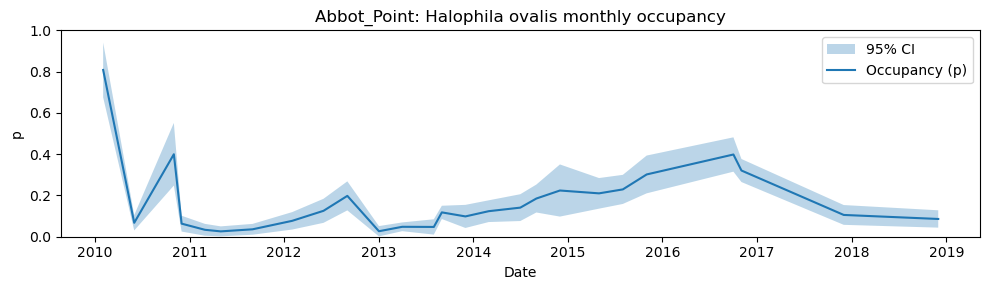

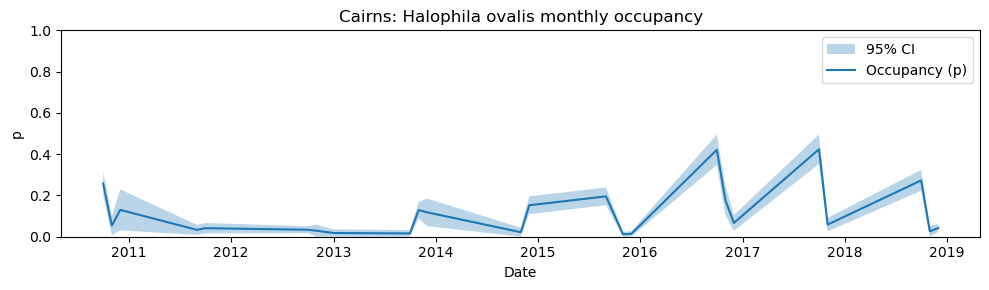

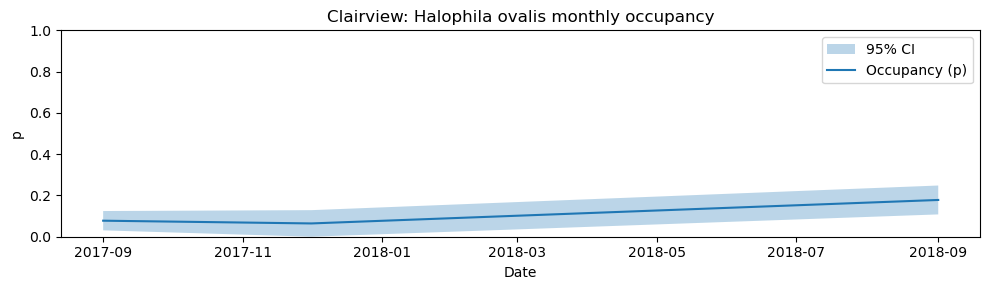

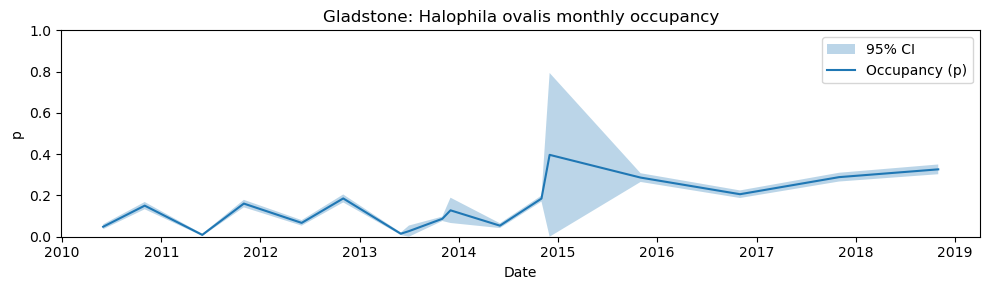

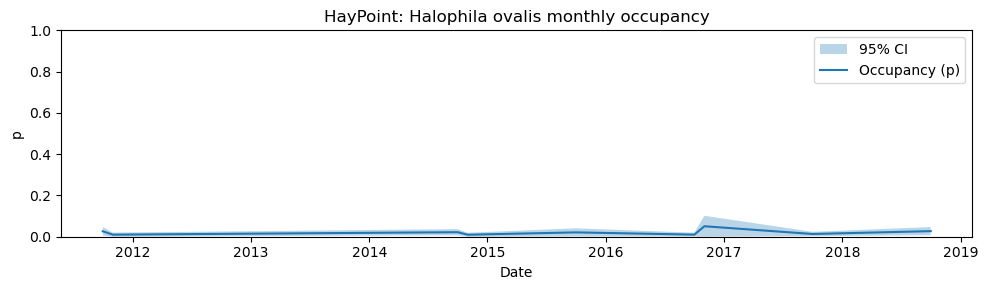

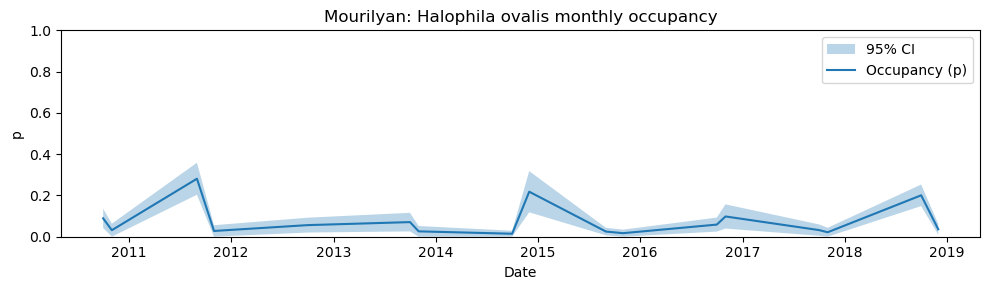

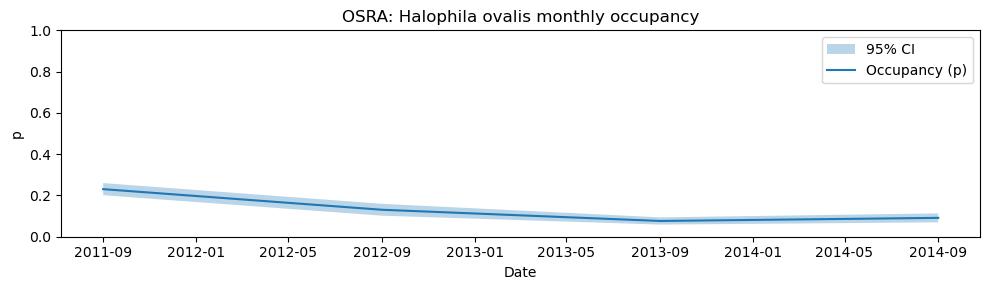

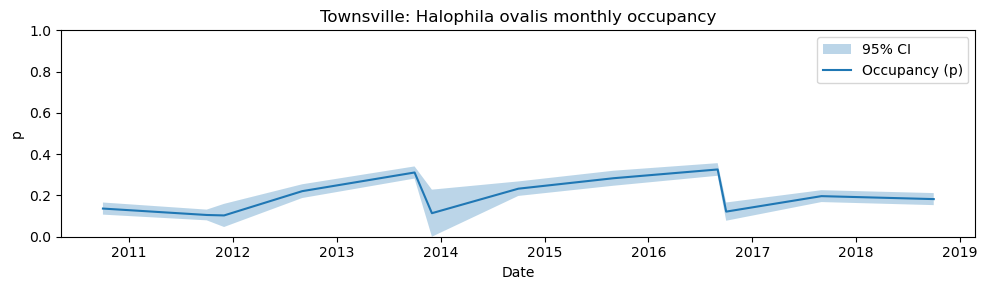

Saved per-site time series to: C:\Users\F\Desktop\ENVI5809\data for analysis\processed\figs


In [5]:
# Per-site time series for HO with 95% CI (auto-compute CI if missing)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

SPECIES_NAME = "Halophila ovalis"

# ensure output dir exists
OUT = (DATA / "figs")
OUT.mkdir(parents=True, exist_ok=True)

# --- add CI if not present: Wilson score interval ---
def add_wilson_ci(df, p_col="p", k_col="n_present", n_col="n_samples", alpha=0.05):
    if {"p_lo","p_hi"}.issubset(df.columns):
        return df
    assert {k_col, n_col}.issubset(df.columns), "Need n_present and n_samples to compute CI."
    z = 1.959963984540054  # ~95%
    k = df[k_col].astype(float)
    n = df[n_col].astype(float).clip(lower=1.0)
    p = (k / n).clip(0, 1)
    denom = 1 + z**2/n
    center = p + z**2/(2*n)
    half = z * np.sqrt((p*(1-p) + z**2/(4*n)) / n)
    lo = ((center - half) / denom).clip(0,1)
    hi = ((center + half) / denom).clip(0,1)
    out = df.copy()
    out[p_col] = p
    out["p_lo"] = lo
    out["p_hi"] = hi
    return out

occ_ci = add_wilson_ci(occ)

def plot_site_series(site):
    df = occ_ci.loc[occ_ci["SURVEY_NAM"]==site].sort_values("date")
    plt.figure(figsize=(10,3))
    plt.fill_between(df["date"], df["p_lo"], df["p_hi"], alpha=0.3, label="95% CI")
    plt.plot(df["date"], df["p"], label="Occupancy (p)")
    plt.title(f"{site}: {SPECIES_NAME} monthly occupancy")
    plt.xlabel("Date"); plt.ylabel("p"); plt.ylim(0,1); plt.legend()
    plt.tight_layout()
    plt.savefig(OUT / f"fig_timeseries_HO_{site}.png", dpi=300)
    plt.show()

for s in sorted(occ_ci["SURVEY_NAM"].unique()):
    plot_site_series(s)

print("Saved per-site time series to:", OUT)